In [3]:
import tensorflow as tf
import numpy as np
import cv2 as cv
import pathlib
import os, random
import matplotlib.pyplot as plt

In [2]:
main_data_path = 'Face_Mask_Detection_YoloDataset/obj/'

def List_Files(full_data_path, img_ext = '.jpg', split_percentage=[80,20]):
    files = []
    discarded = 0
    masked_instance = 0

    for r, d, f in os.walk(full_data_path):
        for file in f:
            if file.endswith(".txt"):

                # checking if there is only one object
                with open(full_data_path + "/" + file, 'r') as fp: 
                    lines = fp.readlines()
                    if len(lines) > 1:
                        discarded += 1
                        continue
                    
                strip = file[0:len(file) - len(".txt")]  
                # secondly, check if the paired image actually exist
                image_path = full_data_path + "/" + strip + img_ext
                if os.path.isfile(image_path):
                    # checking the class. '0' means masked, '1' for unmasked
                    if lines[0][0] == '0':
                        masked_instance += 1
                    files.append(strip)

    size = len(files)   
    print(str(discarded) + " file(s) discarded")
    print(str(size) + " valid case(s)")
    print(str(masked_instance) + " are masked cases")

    random.shuffle(files)

    split_training = int((split_percentage[0] * size) / 100)
    split_validation = split_training + int(split_percentage[1] * size / 100)
    print("index till training images are taken : ",split_training)
    print("index till validation images are taken : ",split_validation)
    
    return files[0:split_training], files[split_training:]

In [3]:
training_files, validation_files = List_Files(main_data_path)

print(str(len(training_files)) + " training files")
print(str(len(validation_files)) + " validation files")

0 file(s) discarded
0 valid case(s)
0 are masked cases
index till training images are taken :  0
index till validation images are taken :  0
0 training files
0 validation files


In [4]:
input_size = 244

def format_image(img, box):
    height, width = img.shape 
    max_size = max(height, width)
    r = max_size / input_size
    new_width = int(width / r)
    new_height = int(height / r)
    new_size = (new_width, new_height)
    resized = cv.resize(img, new_size, interpolation= cv.INTER_LINEAR)
    new_image = np.zeros((input_size, input_size), dtype=np.uint8)
    new_image[0:new_height, 0:new_width] = resized

    x, y, w, h = box[0], box[1], box[2], box[3]
    new_box = [int((x - 0.5*w)* width / r), int((y - 0.5*h) * height / r), int(w*width / r), int(h*height / r)]

    return new_image, new_box

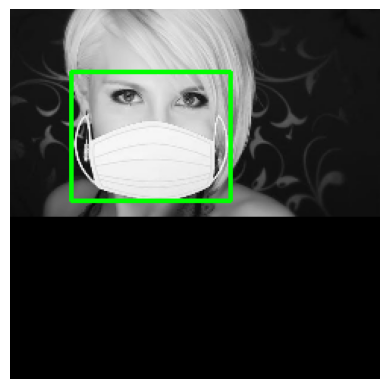

In [5]:
temp_img = cv.imread("Face_Mask_Detection_YoloDataset/obj/5-with-mask.jpg", cv.IMREAD_GRAYSCALE)
temp_box = [0.38183279742765275, 0.6171428571428571, 0.43569131832797425, 0.6285714285714286]

temp_img_formated, box = format_image(temp_img, temp_box)

temp_color_img = cv.cvtColor(temp_img_formated, cv.COLOR_GRAY2RGB)

cv.rectangle(temp_color_img, box, (0, 255, 0), 2)

plt.imshow(temp_color_img)
plt.axis("off")
plt.show()

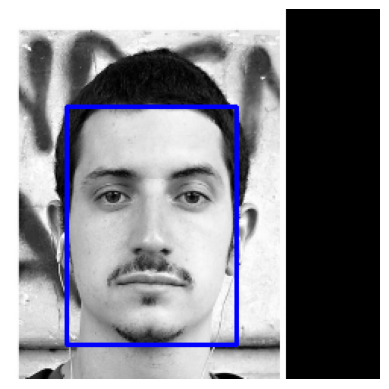

In [6]:
temp_img = cv.imread("Face_Mask_Detection_YoloDataset/obj/149.jpg", cv.IMREAD_GRAYSCALE)
temp_box = [0.5171875, 0.5911214953271028, 0.621875, 0.6495327102803738]

temp_img_formated, box = format_image(temp_img, temp_box)

temp_color_img = cv.cvtColor(temp_img_formated, cv.COLOR_GRAY2RGB)

cv.rectangle(temp_color_img, box, (0, 0, 255), 2)

plt.imshow(temp_color_img)
plt.axis("off")
plt.show()

In [5]:
def data_load(files, full_data_path = "Face_Mask_Detection_YoloDataset/obj/", image_ext = ".jpg"):
    X = []
    Y = []

    for file in files:
        img = cv.imread(os.path.join(full_data_path, file + image_ext), cv.IMREAD_GRAYSCALE)

        k = 1

        with open(full_data_path + file + ".txt", 'r') as fp: 
            line = fp.readlines()[0]
            if line[0] == '0':       # '0' means masked
                k = 0

            box = np.array(line[1:].split(), dtype=float)

        img, box = format_image(img, box)
        img = img.astype(float) / 255.  # normalization
        box = np.asarray(box, dtype=float) / input_size  # normalization of bounding box
        label = np.append(box, k)

        X.append(img)
        Y.append(label)

    X = np.array(X)
    X = np.expand_dims(X, axis=3)
    X = tf.convert_to_tensor(X, dtype=tf.float32)
    Y = tf.convert_to_tensor(Y, dtype=tf.float32)

    result = tf.data.Dataset.from_tensor_slices((X, Y))

    return result

In [6]:
raw_train_ds = data_load(training_files)
raw_validation_ds = data_load(validation_files)

In [7]:
CLASSES = 2

def format_instance(image, label):
    return image, (tf.one_hot(int(label[4]), CLASSES), [label[0], label[1], label[2], label[3]])

In [8]:
BATCH_SIZE = 32

def tune_training_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # The dataset be repeated indefinitely.
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [9]:
train_ds = tune_training_ds(raw_train_ds)
print(train_ds.take(1))

<TakeDataset element_spec=(TensorSpec(shape=(None, 244, 244, 1), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)))>


In [10]:
def tune_validation_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(len(validation_files) // 4)
    dataset = dataset.repeat()
    return dataset

In [11]:
validation_ds = tune_validation_ds(raw_validation_ds)

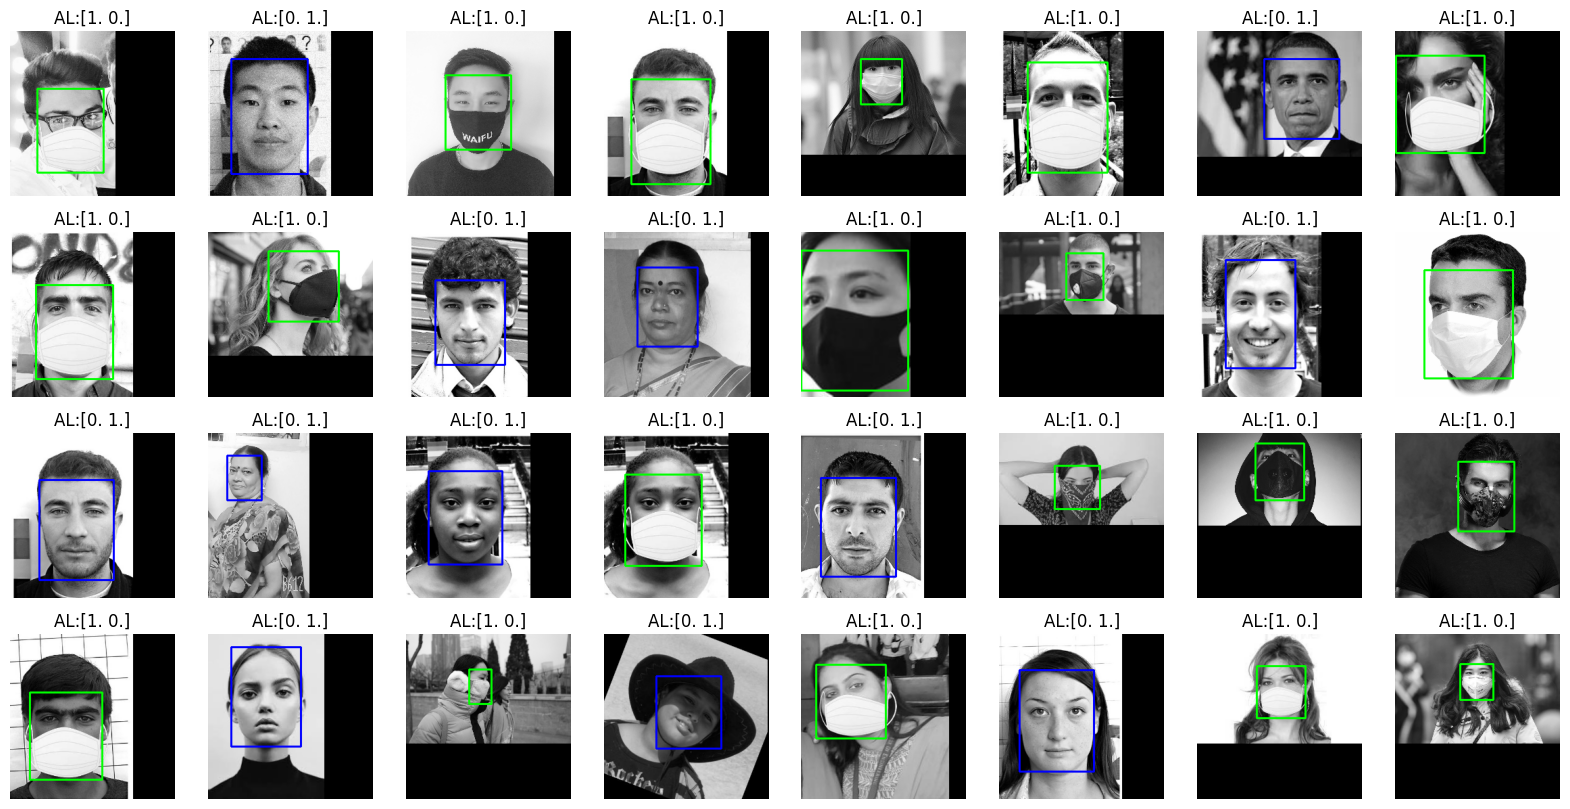

In [12]:
plt.figure(figsize=(20, 10))
for images, labels in train_ds.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(4, BATCH_SIZE//4, i + 1)
        label = labels[0][i]
        box = (labels[1][i] * input_size)
        box = tf.cast(box, tf.int32)

        image = images[i].numpy().astype("float") * 255.0
        image = image.astype(np.uint8)
        image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

        color = (0, 0, 255)
        if label[0] > 0:
            color = (0, 255, 0)

        cv.rectangle(image_color, box.numpy(), color, 2)
        plt.title(f"AL:{label}")
        plt.imshow(image_color)
        plt.axis("off")

In [74]:
# VGG-16 model implementation
DROPOUT_FACTOR1 = 0.5

def Feature_Extractor(inputs):
    x = tf.keras.layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(input_size, input_size, 1))(inputs)
    x = tf.keras.layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(512, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(512, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(512, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(512, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(512, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(512, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.Dropout(DROPOUT_FACTOR1)(x)
    x = tf.keras.layers.MaxPooling2D(2,2)(x)

    return x


def model_adaptor(inputs):
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(4096, activation='relu')(x)
    return x


def classifier_head(inputs):
    return tf.keras.layers.Dense(CLASSES, activation='softmax', name='classifier_head')(inputs)


def regressor_head(inputs):
    return tf.keras.layers.Dense(4, name='regressor_head')(inputs)

def build_model(inputs):
    
    feature_extractor = Feature_Extractor(inputs)

    Model_adaptor = model_adaptor(feature_extractor)

    classification_head = classifier_head(Model_adaptor)

    Regressor_head = regressor_head(Model_adaptor)

    model = tf.keras.Model(inputs = inputs, outputs = [classification_head, Regressor_head])

    model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss = {'classifier_head' : 'categorical_crossentropy', 'regressor_head' : 'mse' }, 
              metrics = {'classifier_head' : 'accuracy', 'regressor_head' : 'mse' })

    return model

In [75]:
VGG_model = build_model(tf.keras.layers.Input(shape=(input_size, input_size, 1,)))

VGG_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 244, 244, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 244, 244, 64  640         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_21 (Conv2D)             (None, 244, 244, 64  36928       ['conv2d_20[0][0]']              
                                )                                                           

In [12]:
# AlexNet model implementation
DROPOUT_FACTOR = 0.5

def Feature_Extractor(inputs):
    x = tf.keras.layers.Conv2D(96, kernel_size=11, strides=4, activation='relu', input_shape=(input_size, input_size, 1))(inputs)
    x = tf.keras.layers.MaxPooling2D(3,2)(x)

    x = tf.keras.layers.Conv2D(256, kernel_size=5, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(3,2)(x)

    x = tf.keras.layers.Conv2D(384, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(384, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(3,2)(x)
    x = tf.keras.layers.Dropout(DROPOUT_FACTOR)(x)

    return x


def Model_Adaptor(inputs):
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(4096, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    return x


def Build_Classifier_Head(inputs):
    return tf.keras.layers.Dense(CLASSES, activation='softmax', name='classifier_head')(inputs)


def Build_Regressor_Head(inputs):
    return tf.keras.layers.Dense(4, name='reggressor_head')(inputs)


def Build_Model(inputs):
    feature_extractor = Feature_Extractor(inputs)
    modell_adaptorr = Model_Adaptor(feature_extractor)
    Classifier_Head = Build_Classifier_Head(modell_adaptorr)
    reggressor_head = Build_Regressor_Head(modell_adaptorr)
    
    Modell = tf.keras.Model(inputs=inputs, outputs=[Classifier_Head, reggressor_head])

    Modell.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss={'classifier_head' : 'categorical_crossentropy', 'reggressor_head' : 'mse'},
                  metrics={'classifier_head' : 'accuracy', 'reggressor_head' : 'mse'})
    
    return Modell

In [13]:
AlexNet_model_final = Build_Model(tf.keras.layers.Input(shape=(input_size, input_size, 1)))

AlexNet_model_final.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 244, 244, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 59, 59, 96)   11712       ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 29, 29, 96)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 29, 29, 256)  614656      ['max_pooling2d[0][0]']      

In [12]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [18]:
EPOCHS = 90
with tf.device('/GPU:0'):
    history = AlexNet_model_final.fit(train_ds,
                        steps_per_epoch=(len(training_files) // BATCH_SIZE),
                        validation_data=validation_ds, validation_steps=1, 
                        epochs=EPOCHS,
                        verbose=1)

Epoch 1/90
32/32 [==============================] - 17s 193ms/step - loss: 9.6109 - classifier_head_loss: 0.9101 - reggressor_head_loss: 8.7009 - classifier_head_accuracy: 0.6514 - reggressor_head_mse: 8.7009 - val_loss: 0.7158 - val_classifier_head_loss: 0.6726 - val_reggressor_head_loss: 0.0432 - val_classifier_head_accuracy: 0.5938 - val_reggressor_head_mse: 0.0432
Epoch 2/90
32/32 [==============================] - 3s 90ms/step - loss: 0.6636 - classifier_head_loss: 0.6324 - reggressor_head_loss: 0.0312 - classifier_head_accuracy: 0.6504 - reggressor_head_mse: 0.0312 - val_loss: 0.6719 - val_classifier_head_loss: 0.6491 - val_reggressor_head_loss: 0.0228 - val_classifier_head_accuracy: 0.5938 - val_reggressor_head_mse: 0.0228
Epoch 3/90
32/32 [==============================] - 3s 90ms/step - loss: 0.6086 - classifier_head_loss: 0.5922 - reggressor_head_loss: 0.0165 - classifier_head_accuracy: 0.6592 - reggressor_head_mse: 0.0165 - val_loss: 0.6148 - val_classifier_head_loss: 0.6005

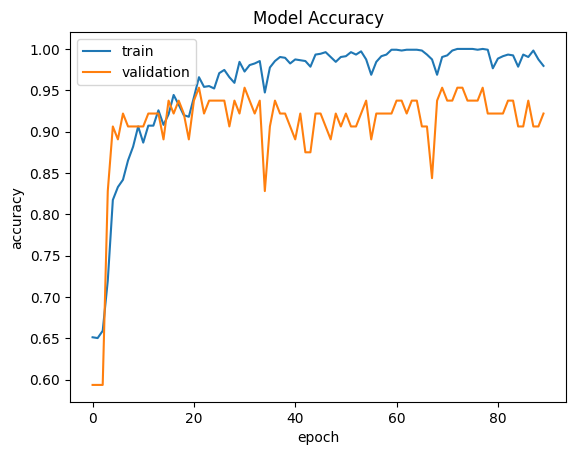

In [19]:
plt.plot(history.history['classifier_head_accuracy'])
plt.plot(history.history['val_classifier_head_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

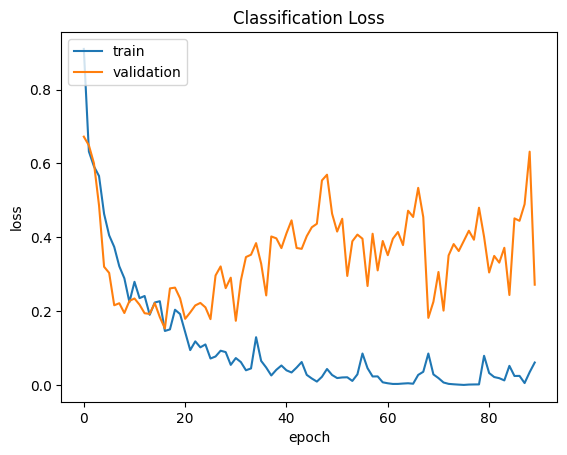

In [20]:
plt.plot(history.history['classifier_head_loss'])
plt.plot(history.history['val_classifier_head_loss'])
plt.title('Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

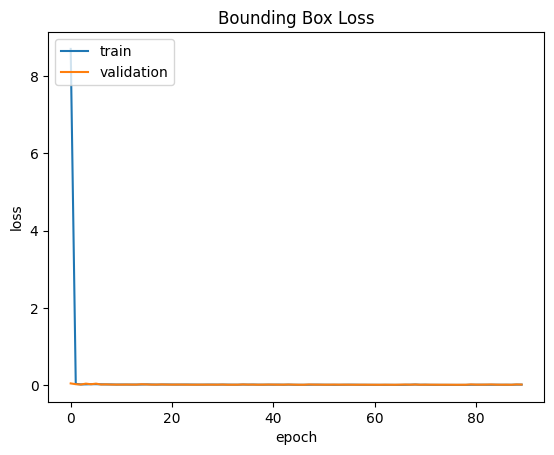

In [21]:
plt.plot(history.history['reggressor_head_loss'])
plt.plot(history.history['val_reggressor_head_loss'])
plt.title('Bounding Box Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [22]:
def intersection_over_union(boxA, boxB):
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
	yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	boxAArea = (boxA[2] + 1) * (boxA[3] + 1)
	boxBArea = (boxB[2] + 1) * (boxB[3] + 1)
	iou = interArea / float(boxAArea + boxBArea - interArea)
	return iou

In [38]:
# def tune_test_ds(dataset):
#     dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
#     dataset = dataset.batch(1) 
#     dataset = dataset.repeat()
#     return dataset

# test_ds = tune_test_ds(raw_test_ds)

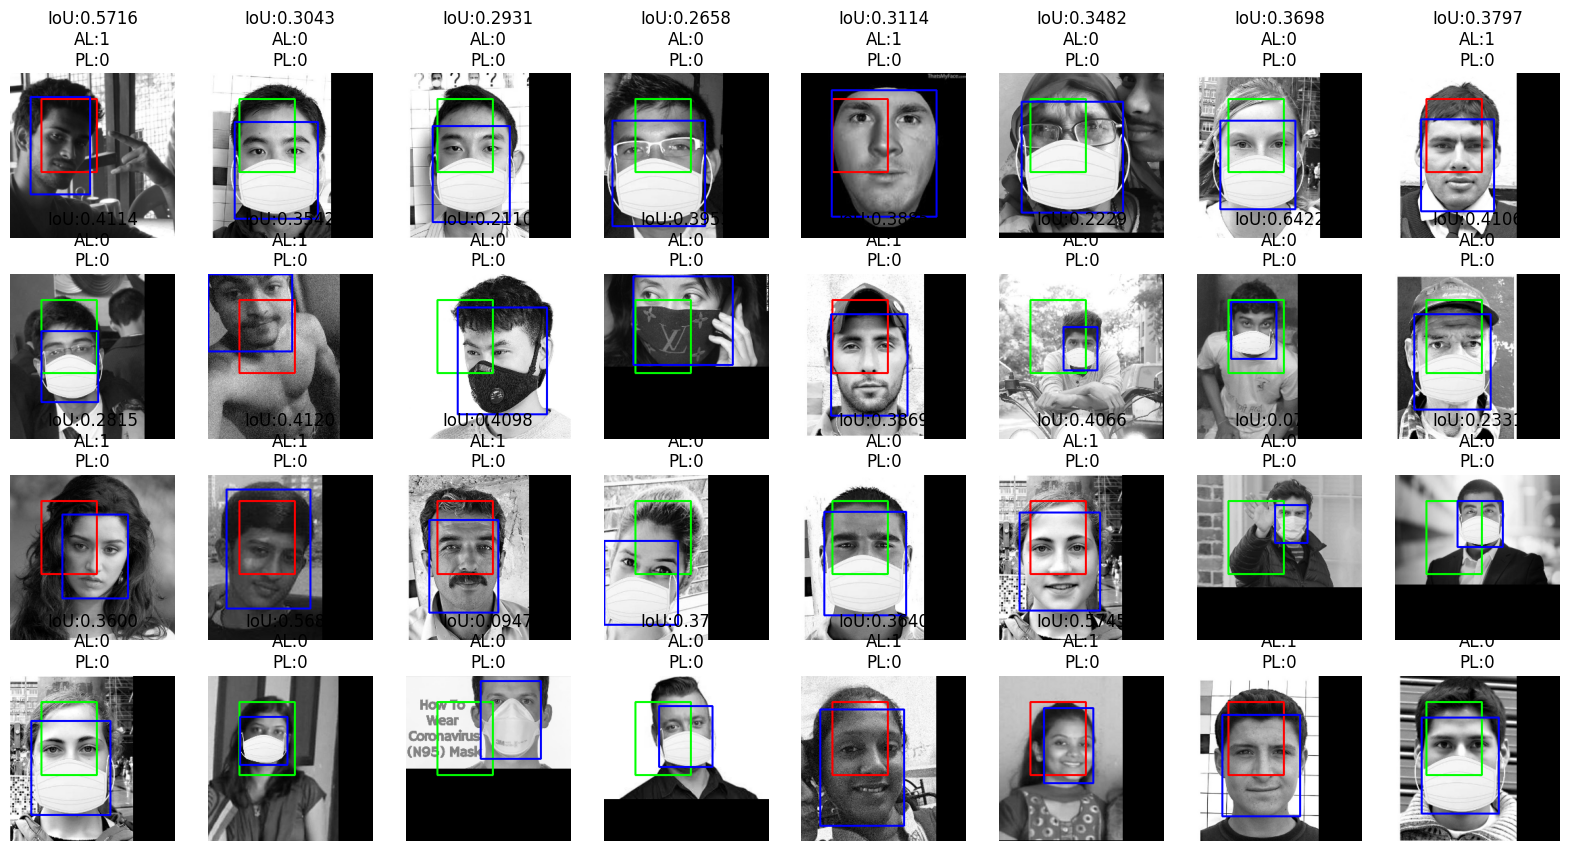

In [23]:
# plt.figure(figsize=(20, 10))
# test_list = list(validation_ds.take(len(validation_files)//4).as_numpy_iterator())
# print(len(test_list))
# image, labels = test_list[0]
model = tf.keras.models.load_model('AlexNet_Model4.h5')

plt.figure(figsize=(20, 10))
for images, labels in validation_ds.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(4, BATCH_SIZE//4, i + 1)
        predictions = AlexNet_model_final(images)
        
        predicted_box = predictions[1][0] * input_size
        predicted_box = tf.cast(predicted_box, tf.int32)
        predicted_label = np.argmax(predictions[0][0])

        label = np.argmax(labels[0][i])  # index of [0, 1]=>1 or [1, 0]=>0
        box = (labels[1][i] * input_size)
        box = tf.cast(box, tf.int32)

        image = images[i].numpy().astype("float") * 255.0
        image = image.astype(np.uint8)
        image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

        ''' 1 = Masked ''' 
        color = (255, 0, 0)
        if (predicted_label==label):
            color = (0, 255, 0)

        cv.rectangle(image_color, predicted_box.numpy(), color, 2)
        cv.rectangle(image_color, box.numpy(), (0, 0, 255), 2)

        IoU = intersection_over_union(predicted_box.numpy(), box.numpy())

        plt.title(f"IoU:{format(IoU, '.4f')}\nAL:{label}\nPL:{predicted_label}")
        plt.imshow(image_color)
        plt.axis("off")

In [24]:
AlexNet_model_final.save('AlexNet_Model_final.h5')

In [13]:
model_loaded = tf.keras.models.load_model('AlexNet_Model_final.h5')

In [28]:
validation_steps = len(validation_files)
result = AlexNet_model_final.evaluate(validation_ds, steps=validation_steps, verbose=1)

259/259 [==============================] - 9s 35ms/step - loss: 0.3246 - classifier_head_loss: 0.3126 - reggressor_head_loss: 0.0120 - classifier_head_accuracy: 0.8919 - reggressor_head_mse: 0.0120


In [32]:
# AlexNet Model 4 accuracy => Overfit hua hai
validation_steps = len(validation_files) 
result = model_loaded.evaluate(validation_ds, steps=validation_steps, verbose=1)

259/259 [==============================] - 9s 33ms/step - loss: 0.3321 - classifier_head_loss: 0.3249 - reggressor_head_loss: 0.0073 - classifier_head_accuracy: 0.9537 - reggressor_head_mse: 0.0073


In [25]:
def preprocess_image(img, input_size=244):
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    height, width = img.shape
    max_size = max(height, width)
    r = max_size / input_size
    new_width = int(width / r)
    new_height = int(height / r)
    new_size = (new_width, new_height)
    resized_img = cv.resize(img, new_size, interpolation= cv.INTER_LINEAR)
    new_img = np.zeros((input_size, input_size, 1), dtype=np.float32)
    new_img[0:new_height, 0:new_width, 0] = resized_img
    new_img = new_img/255.
    new_img = np.expand_dims(new_img, axis=0)
    return new_img


def predict_frame(frame):
    preprocessed_img = preprocess_image(frame)
    prediction = AlexNet_model_final(preprocessed_img)

    class_probabilities = prediction[0][0].numpy()
    bounding_box = prediction[1][0].numpy()

    predicted_class_index = np.argmax(class_probabilities)
    x, y, w, h = bounding_box

    return predicted_class_index, (x, y, w, h)

cap = cv.VideoCapture(0)

while True:
    ret, frame = cap.read()
    original_height, original_width = frame.shape[:2]
    predicted_class, bounding_box = predict_frame(frame)

    x, y, w, h = bounding_box
    x = x*original_height
    y = y*original_width
    h = h*original_height
    w = w*original_width
    cv.rectangle(frame, (int(x), int(y)), (int(x + w), int(y + h)), (0, 255, 0), 2)

    
    if predicted_class==0:
        class_text = 'Class: Unmasked'
    else:
        class_text = 'Class: Masked'
    cv.putText(frame, class_text, (10, 30), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv.LINE_AA)

    cv.imshow('Object Detection', frame)

    # Break the loop if 'q' key is pressed
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv.destroyAllWindows()

# test = cv.imread("Face_Mask_Detection_YoloDataset/obj/149.jpg")
# print(predict_frame(test))

In [ ]:
quantization_dataset = validation_ds.take(200) 

def representative_data_gen():
  for input_images, _ in quantization_dataset:
    yield [tf.dtypes.cast(input_images, tf.float32)]

converter = tf.lite.TFLiteConverter.from_keras_model(model_loaded)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# converter.target_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.target_spec.supported_types = [tf.int8]
# # Set the input and output tensors to uint8
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

In [11]:
def preprocess_image(img, input_size=244):
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    height, width = img.shape
    max_size = max(height, width)
    r = max_size / input_size
    new_width = int(width / r)
    new_height = int(height / r)
    new_size = (new_width, new_height)
    resized_img = cv.resize(img, new_size, interpolation= cv.INTER_LINEAR)
    new_img = np.zeros((input_size, input_size, 1), dtype=np.uint8)
    new_img[0:new_height, 0:new_width, 0] = resized_img
    new_img = np.expand_dims(new_img, axis=0)
    return new_img



interpreter = tf.lite.Interpreter(model_path='tflite_models/tflite_model_quant.tflite')
interpreter.allocate_tensors()
input_tensor_index = interpreter.get_input_details()[0]['index']
output = interpreter.get_output_details()

cap = cv.VideoCapture(0)

while True:
    ret, frame = cap.read()
    original_height, original_width = frame.shape[:2]
    preprocessed_frame = preprocess_image(frame)
    interpreter.set_tensor(input_tensor_index, preprocessed_frame)
    interpreter.invoke()

    bounding_box = interpreter.get_tensor(output[0]['index'])
    class_probability = np.argmax(interpreter.get_tensor(output[1]['index'])[0])

    x, y, w, h = bounding_box[0]
    x = x*original_height
    y = y*original_width
    h = h*original_height
    w = w*original_width
    cv.rectangle(frame, (int(x), int(y)), (int(x + w), int(y + h)), (0, 255, 0), 2)

    if class_probability==0:
        class_text = 'Class: Masked'
    else:
        class_text = 'Class: Unmasked'
    cv.putText(frame, class_text, (10, 30), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv.LINE_AA)

    cv.imshow('Object Detection', frame)

    if cv.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv.destroyAllWindows()

In [12]:

def preprocess_image(img, input_size=244):
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    height, width = img.shape
    max_size = max(height, width)
    r = max_size / input_size
    new_width = int(width / r)
    new_height = int(height / r)
    new_size = (new_width, new_height)
    resized_img = cv.resize(img, new_size, interpolation=cv.INTER_LINEAR)
    new_img = np.zeros((input_size, input_size, 1), dtype=np.uint8)
    new_img[0:new_height, 0:new_width, 0] = resized_img
    new_img = np.expand_dims(new_img, axis=0)
    return new_img


interpreter = tf.lite.Interpreter(model_path='tflite_models/tflite_model_quant.tflite')
interpreter.allocate_tensors()

# output = interpreter.tensor(interpreter.get_output_details()[0]['index'])

# Load an image
image_path = 'test_data/with_maskb (7).jpg'
img = cv.imread(image_path)

# Preprocess the image
preprocessed_img = preprocess_image(img)

# Set the input tensor
input_tensor_index = interpreter.get_input_details()[0]['index']
interpreter.set_tensor(input_tensor_index, preprocessed_img)

# Invoke the interpreter
interpreter.invoke()

input_details = interpreter.get_input_details()[0]['index']
print(input_details)
print(interpreter.get_input_details())

# Get the output tensor details
output_details = interpreter.get_output_details()
print("Output Tensor Details:")
print(output_details)
print(len(output_details))

# Get the output tensor values
output_values = interpreter.get_tensor(output_details[0]['index'])
print("\nOutput Tensor Values:")
print(output_values)

output_values = interpreter.get_tensor(output_details[1]['index'])
print("\n2nd Output Tensor Values:")
print(output_values)

0
[{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([  1, 244, 244,   1]), 'shape_signature': array([ -1, 244, 244,   1]), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.003921568859368563, 0), 'quantization_parameters': {'scales': array([0.00392157], dtype=float32), 'zero_points': array([0]), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output Tensor Details:
[{'name': 'StatefulPartitionedCall:1', 'index': 35, 'shape': array([1, 4]), 'shape_signature': array([-1,  4]), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.0041629415936768055, 12), 'quantization_parameters': {'scales': array([0.00416294], dtype=float32), 'zero_points': array([12]), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'StatefulPartitionedCall:0', 'index': 36, 'shape': array([1, 2]), 'shape_signature': array([-1,  2]), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.00390625, 0), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_point